In [13]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [3.5, 3]
matplotlib.rcParams['axes.grid'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [3]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [4]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')
load_workspace(vars(), '../data/20200130-100802-mnist_config')

c:\users\canli\.venv\py37\lib\site-packages\dill\_dill.py:473: UserWarning: This figure was saved with matplotlib version 3.1.1 and is unlikely to function correctly.
  obj = StockUnpickler.load(self)


Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [5]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [6]:
from lib_ecc import *

## Construct NN

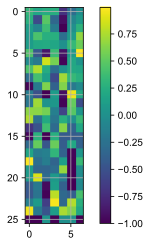

In [7]:
nn = NN_dpe(weights)
nn.Gratio = 100e-6
plt.imshow(nn.Mconv); plt.colorbar()

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


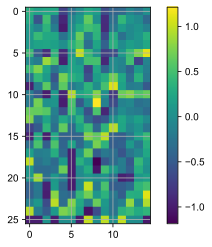

In [8]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

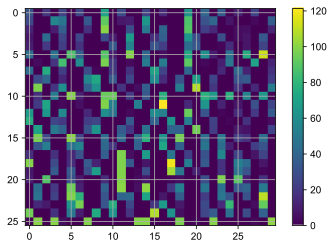

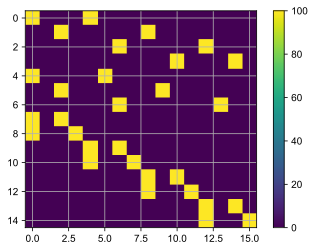

In [9]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

# Load the data

In [10]:
# dir_data = '/Volumes/T7 Touch/SuperT/' # mac
dir_data = 'X:/SuperT/'

load_workspace(vars(), filename=dir_data+ '20200624-081921-multi-gain-repeat-all')

Loaded: In, Out, weights, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, acc, result, x1, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, delta, Delta, m, k, M_conv_ecc, G_conv_ecc, G_parity_ecc, Gtarget, rs, cs, Msel, data, i, N_IMG, vectors_list, output_list, img, output, output_soft, output_cor, gain_list, output_gain, gain, gain_th, gain_value, lin_cor_gain, th_rel, lin_cor, idx, y1_raw_list, y1_ecc_list, y1_soft_list, n_detected, n_corrected, n_other, y1, y1_soft, S, s, yy, ecc_loc, y1_corrected, y1_raw, y1_ecc, err_raw, err_ecc, 


In [11]:
N_IMG=10

y1_raw = np.array(y1_raw_list[:N_IMG])
y1_soft = np.array(y1_soft_list[:N_IMG])
y1_ecc = np.array(y1_ecc_list[:N_IMG])

y1_raw.shape, y1_soft.shape, y1_ecc.shape

((10, 400, 15), (10, 400, 15), (10, 400, 15))

Text(0, 0.5, 'Experimentoutput')

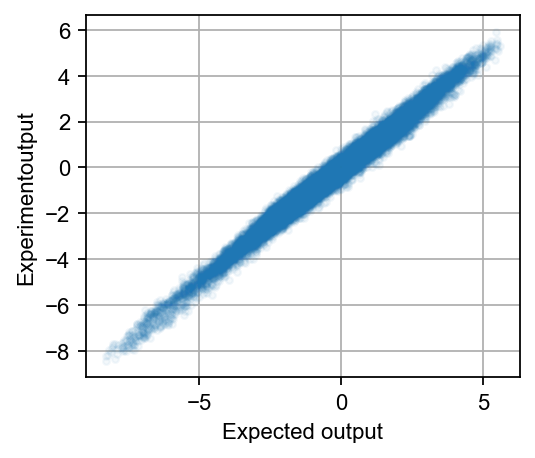

In [16]:
%config InlineBackend.figure_formats = ['retina']

plt.plot(y1_raw.reshape(-1), y1_soft.reshape(-1), '.', alpha=0.05)
plt.xlabel('Expected output')
plt.ylabel('Experimentoutput')

Text(0, 0.5, 'Count')

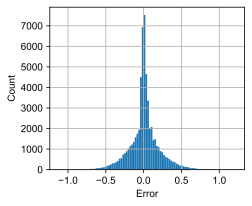

In [20]:
%config InlineBackend.figure_formats = ['svg']

_ = plt.hist(y1_raw.reshape(-1) - y1_soft.reshape(-1), bins=100)
plt.yscale('linear')

plt.xlabel('Error')
plt.ylabel('Count')

(-2.0, 2.0)

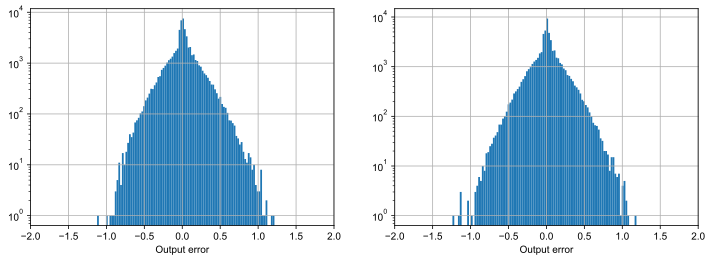

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-2,2))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-2,2))

In [14]:
y1_raw = np.array(y1_raw_list).reshape(-1, 15)
y1_soft = np.array(y1_soft_list).reshape(-1, 15)
# y1_ecc = np.array(y1_ecc_list).reshape()

In [18]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list_list = []

for delta in tqdm(delta_list):
    y1_ecc_list = []
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

#     for y1_raw in y1_raw_list:
    y1_ecc_list.append( correct_ecc(y1_raw, ecc) )
        
    y1_ecc_list_list.append(y1_ecc_list)

100%|████████████████████████████████████████████████████████████| 24/24 [04:58<00:00, 12.44s/it]


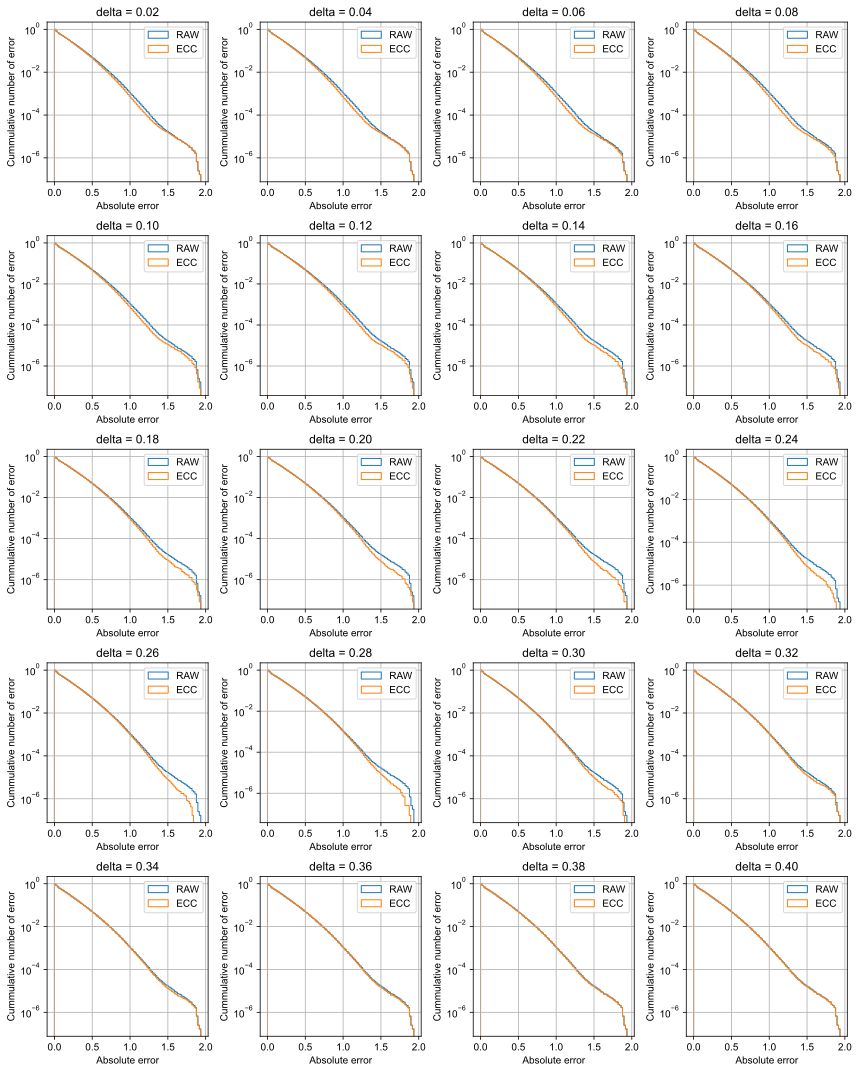

In [20]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(12,15))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1_ecc - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

# First 100

In [172]:
# dir_data = '/Volumes/T7 Touch/SuperT/' # mac
dir_data = 'X:/SuperT/'

load_workspace(vars(), filename=dir_data+ '20200624-081921-multi-gain-repeat-all')

Loaded: In, Out, weights, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, acc, result, x1, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, delta, Delta, m, k, M_conv_ecc, G_conv_ecc, G_parity_ecc, Gtarget, rs, cs, Msel, data, i, N_IMG, vectors_list, output_list, img, output, output_soft, output_cor, gain_list, output_gain, gain, gain_th, gain_value, lin_cor_gain, th_rel, lin_cor, idx, y1_raw_list, y1_ecc_list, y1_soft_list, n_detected, n_corrected, n_other, y1, y1_soft, S, s, yy, ecc_loc, y1_corrected, y1_raw, y1_ecc, err_raw, err_ecc, 


In [173]:
N_IMG = 1000

y1_raw = np.array(y1_raw_list[:N_IMG])
y1_soft = np.array(y1_soft_list[:N_IMG])
y1_ecc = np.array(y1_ecc_list[:N_IMG])

y1_raw.shape, y1_soft.shape, y1_ecc.shape

((1000, 400, 15), (1000, 400, 15), (1000, 400, 15))

(-2.0, 2.0)

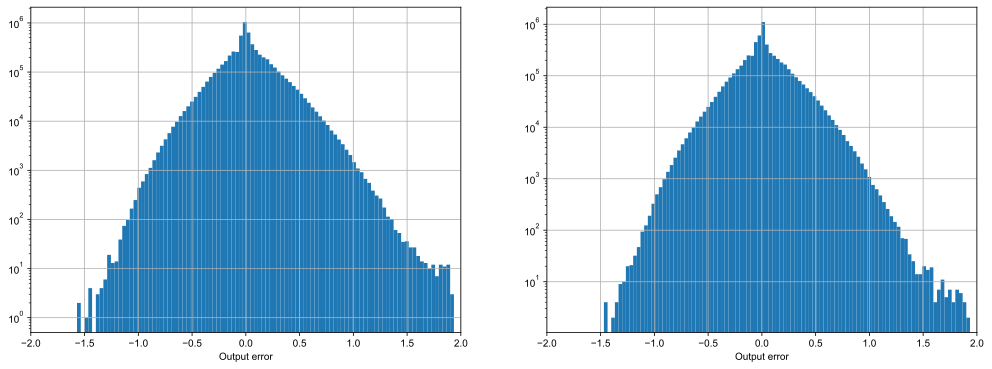

In [174]:
plt.figure(figsize=(17, 6))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-2,2))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-2,2))

In [41]:
y1_raw = np.array(y1_raw).reshape(-1, 15)
y1_soft = np.array(y1_soft).reshape(-1, 15)
# y1_ecc = np.array(y1_ecc_list).reshape()

delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list_list = []

for delta in tqdm(delta_list):
    y1_ecc_list = []
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

#     for y1_raw in y1_raw_list:
    y1_ecc_list.append( correct_ecc(y1_raw, ecc) )
        
    y1_ecc_list_list.append(y1_ecc_list)

100%|████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 15.56it/s]


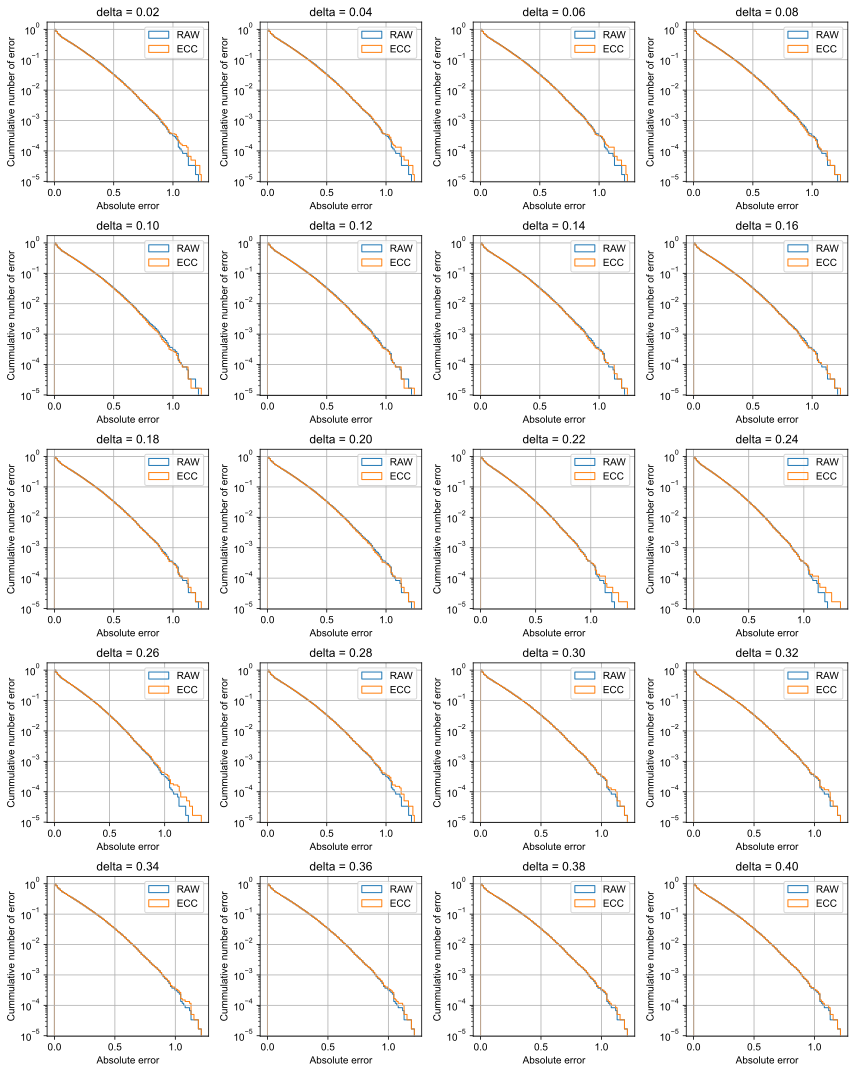

In [42]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(12,15))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1_ecc - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

# Artifitial noise

In [190]:
y1_raw = np.array(y1_raw).reshape(-1, 15)
y1_soft = np.array(y1_soft).reshape(-1, 15)

In [191]:
y1_noise = np.array(y1_raw.copy())

for r in range(y1_noise.shape[0]):
    c = int(y1_noise.shape[1] * np.random.rand())
    
    if np.random.rand() < 0.1:
        y1_noise[r,c] += np.random.randn() * 5

In [192]:
# plt.figure(figsize=(4,3))
# plt.plot(y1_soft.reshape(-1), y1_noise.reshape(-1), '.', ms=0.2)

# plt.xlabel('Expected output')
# plt.ylabel('Experimental output with artifitial noise')

Text(0, 0.5, 'Count')

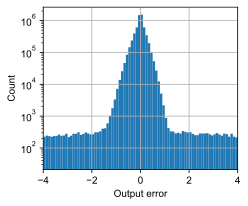

In [193]:
plt.figure(figsize=(3.5,3))

bins = np.arange(-10, 10, 0.1)
_ = plt.hist(y1_soft.reshape(-1)- y1_noise.reshape(-1), bins)
plt.yscale('log')
plt.xlim(-4,4)
plt.xlabel('Output error')
plt.ylabel('Count')

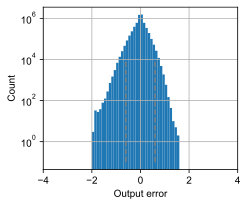

In [194]:
plt.figure(figsize=(3.5,3))

_ = plt.hist(y1_soft.reshape(-1)- y1_raw.reshape(-1), bins)
plt.yscale('log')
plt.xlim(-4,4)
plt.xlabel('Output error')
plt.ylabel('Count')

plt.plot([0.6, 0.6], [0.1, 1e4], '--', color='gray')
plt.plot([-0.6, -0.6], [0.1, 1e4], '--', color='gray')

In [195]:
y1_noise.shape

(400000, 15)

In [196]:
delta_list = np.arange(0.1, 2.1, 0.1)

y1_ecc_list = []

for delta in tqdm(delta_list):
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y1_ecc_list.append( correct_ecc(y1_noise, ecc) )

100%|████████████████████████████████████████████████████████████| 20/20 [01:14<00:00,  3.73s/it]


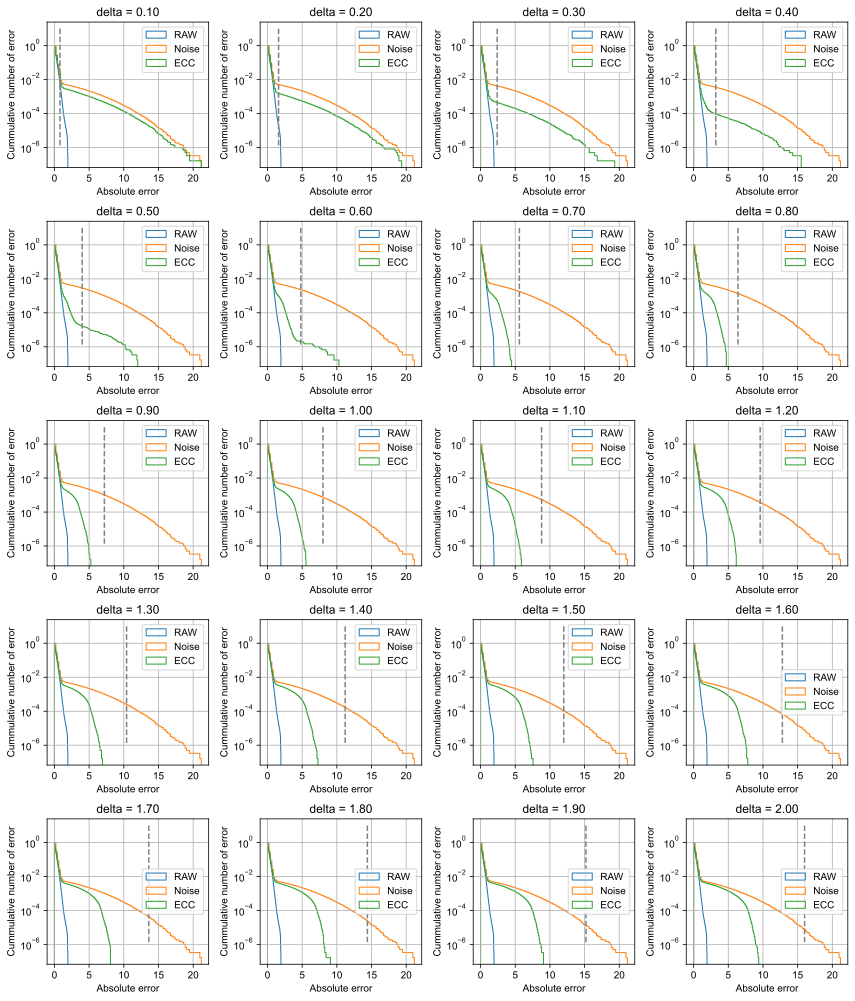

In [197]:
plt.figure(figsize=(12, 14))

for i in range(20):
    
    plt.subplot(5,4,i+1)

    y1_ecc = y1_ecc_list[i]

    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_noise = (y1_noise - y1_soft).reshape(-1)
    err_ecc = (y1_ecc  - y1_soft).reshape(-1)
    
    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_noise), density=True, histtype='step', cumulative=-1,
            label='Noise', bins=100)
    
    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
    Delta = delta_list[i] * 8
    plt.plot([Delta, Delta], [10, 1e-6], '--', color='gray')
    
plt.tight_layout()

In [198]:
def detect_ecc(y1, ecc):
    y1_ecc = y1.copy()
    
    err_idxes = []

    for i, yy in enumerate(y1_ecc):
        ecc_loc, ecc_range = ecc.decode(yy)
        
        if ecc_loc != -1:
            # error 
            err_idxes.append(i)

    return err_idxes

In [209]:
# delta_list = np.arange(0.1, 2.1, 0.1)

# y1_ecc_list = []

delta = 0.5

# for delta in tqdm(delta_list):
Delta = 8 * delta
ecc = dpeECC(nn.Mconv, delta, Delta)

err_idxes = detect_ecc(y1_noise, ecc)

In [210]:
len(err_idxes)

32557

In [211]:
len(y1_noise)

400000

(-8.0, 8.0)

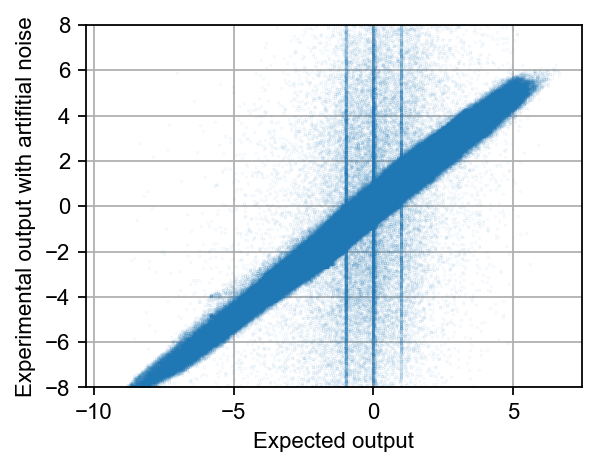

In [220]:
%config InlineBackend.figure_formats = ['retina']
plt.figure(figsize=(4,3))
plt.plot(y1_soft.reshape(-1), y1_noise.reshape(-1), '.', ms=0.05)

plt.xlabel('Expected output')
plt.ylabel('Experimental output with artifitial noise')
plt.ylim(-8,8)

Text(0, 0.5, 'Experimental output with artifitial noise')

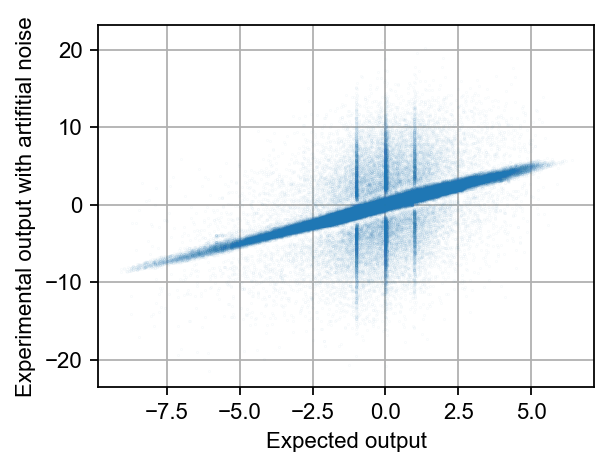

In [218]:
%config InlineBackend.figure_formats = ['retina']
plt.figure(figsize=(4,3))
plt.plot(y1_soft[err_idxes].reshape(-1), y1_noise[err_idxes].reshape(-1), '.', ms=0.02)

plt.xlabel('Expected output')
plt.ylabel('Experimental output with artifitial noise')

In [214]:
idx_normal = list(set(np.arange(len(y1_noise))) - set(err_idxes))
len(idx_normal)

367443

(-8.0, 8.0)

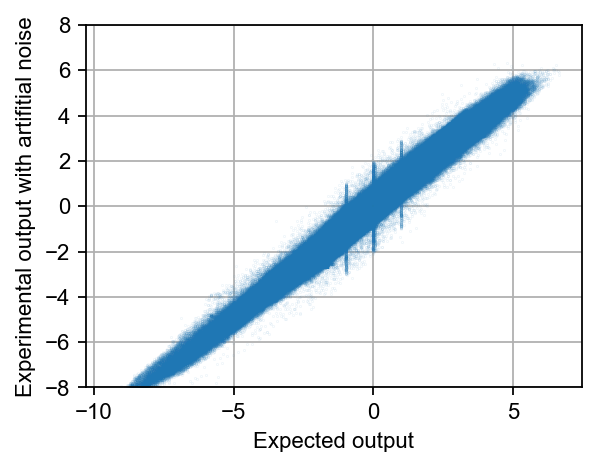

In [222]:
%config InlineBackend.figure_formats = ['retina']
plt.figure(figsize=(4,3))
plt.plot(y1_soft[idx_normal].reshape(-1), y1_noise[idx_normal].reshape(-1), '.', ms=0.05)

plt.xlabel('Expected output')
plt.ylabel('Experimental output with artifitial noise')
plt.ylim(-8,8)

In [216]:
err_ecc = y1_soft[idx_normal].reshape(-1) - y1_noise[idx_normal].reshape(-1)
err_noise = y1_soft.reshape(-1) - y1_noise.reshape(-1)
err_raw = y1_soft.reshape(-1) - y1_raw.reshape(-1)

Text(0, 0.5, 'Count')

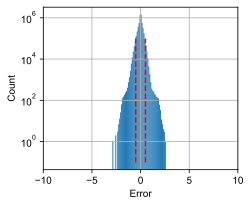

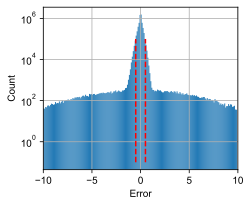

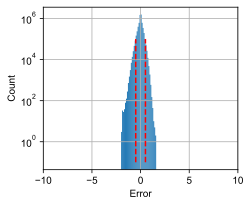

In [217]:
%config InlineBackend.figure_formats = ['svg']

plt.figure(figsize=(3.5,3))
bins = np.arange(-10, 10, 0.1)
_ = plt.hist(err_ecc, bins=bins)
plt.yscale('log')
plt.xlim(-10,10)
plt.plot([delta, delta], [0.1, 1e5], '--', color='red')
plt.plot([-delta, -delta], [0.1, 1e5], '--', color='red')
plt.xlabel('Error')
plt.ylabel('Count')

plt.figure(figsize=(3.5,3))
_ = plt.hist(err_noise, bins=bins)
plt.yscale('log')
plt.xlim(-10,10)
plt.plot([delta, delta], [0.1, 1e5], '--', color='red')
plt.plot([-delta, -delta], [0.1, 1e5], '--', color='red')
plt.xlabel('Error')
plt.ylabel('Count')

plt.figure(figsize=(3.5,3))
_ = plt.hist(err_raw, bins=bins)
plt.yscale('log')
plt.xlim(-10,10)
plt.plot([delta, delta], [0.1, 1e5], '--', color='red')
plt.plot([-delta, -delta], [0.1, 1e5], '--', color='red')
plt.xlabel('Error')
plt.ylabel('Count')